# 코로나 이후 이동 수단의 변화에 대하여  

## 목차
+ 데이터 전처리 
+ 코로나 데이터 시각화
+ DSRC 데이터 시각화
+ 교통카드 데이터 시각화
+ KT 유동인구 데이터 시각화
+ 서울시 공공자전거 데이터 & 날씨 데이터 시각화
+ 결론
+ 대안책

## 데이터
+ DACON 제공 데이터
    + 한국도로공사 DSRC 데이터
    + 한국교통안전공단 교통카드 데이터
    + KT 행정동별 유동인구 데이터
    + DS4C팀 COVID-19 데이터
+ 외부 데이터
    + [서울시 공공자전거 이용현황](https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do) - 2019.01.01 ~ 2020.06.30
    + [서울시 공공자전거 신규가입자 정보(일별)](https://data.seoul.go.kr/dataList/OA-15243/S/1/datasetView.do) - 2019.01.01 ~ 2020.06.30
    + [기상청 기상자료개방포털, 기온 데이터](https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70) - 서울 지점, 2019.01.01 ~ 현재
    + [기상청 기상자료개발포털, 강수량 데이터](https://data.kma.go.kr/stcs/grnd/grndRnList.do?pgmNo=69) - 서울 지점, 2019.01.01 ~ 현재


## 데이터 전처리  
### DSRC 데이터 전처리  
DSRC 데이터 양이 워낙 많아서 모든 데이터를 다 분석하는 것을 어렵다고 판단하여 **출근 첨두시(오전 7-10시)**에 대해 분석하기 위해 모든 날짜에 대해 해당 시간대의 데이터만 필터링하여 데이터를 새로 생성했습니다. 대용량 파일을 가장 빠르게 읽을 수 있는 fread 함수를 사용하기 위해 data.table 패키지를 사용했으며, 조금이라도 빨리 필터링 된 데이터를 저장하기 위해 병렬 처리 패키지인 doParallel 패키지를 사용했습니다.

In [ ]:
library(doParallel)
library(data.table)

cat("\014")
rm(list=ls())
gc()

savedsrc = function(a, b) {
  setwd(a)
  
  cl <- makeCluster(8)
  registerDoParallel(cl)
  
  flist = list.files()
  
  foreach(i=1:length(flist)) %dopar% {
    require(data.table)
    
    dt = fread(flist[i],encoding = "UTF-8")
    dt7to10 = dt[dt$RSE수집시분초>70000 & dt$RSE수집시분초<100000]
    # 위에 코드가 게시글로 올리면 이상하게 나오네요, and 연산자 때문에 그런 것 같은데 다운 받아 보시면 제대로 나옵니다.
    
    write.csv(dt7to10[,-grep('V10', colnames(dt7to10)),with=F], paste0(b,flist[i]), row.names = F, fileEncoding = "UTF-8")
    
  }
  stopCluster(cl)
  
}

savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201901", "../DSRC_201901_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201902", "../DSRC_201902_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201903", "../DSRC_201903_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201904", "../DSRC_201904_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201905", "../DSRC_201905_0710/")

savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202001", "../DSRC_202001_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202002", "../DSRC_202002_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202003", "../DSRC_202003_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202004", "../DSRC_202004_0710/")
savedsrc("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202005", "../DSRC_202005_0710/")

이렇게 모든 날짜에 대해 출근 첨두시만 필터링 된 데이터를 통해 각 일자별, 시간대별로 몇 대의 차량이 RSE 검지기에 탐지 되었는지 카운팅하여 하나의 파일로 만들었습니다.

In [ ]:
counting = function(a) {
  setwd(a)
  flist = list.files()
    
  cl <- makeCluster(8)
  registerDoParallel(cl)
  
  d = foreach(i=1:length(flist), .combine = rbind) %dopar% {
    require(data.table)
    dt = fread(flist[i],encoding = "UTF-8")
    dt7to10 = dt[dt$RSE수집시분초>70000 & dt$RSE수집시분초<100000]
    # 위에 코드가 게시글로 올리면 이상하게 나오네요, and 연산자 때문에 그런 것 같은데 다운 받아 보시면 제대로 나옵니다.
    dt7to10$time = substr(dt7to10$RSE수집시분초,1,1)
    final <- dt7to10[!duplicated(dt7to10$가상OBU_ID),]
    tmp = final[, .(count = .N), by = list(date=기준일자, time)]
    tmp
  }
  write.table(d, "../DSRC_count.csv", sep = ",", col.names = !file.exists("../DSRC_count.csv"), append = T, row.names = F)
  
  stopCluster(cl)
}

counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201901_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201902_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201903_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201904_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_201905_0710")

counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202001_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202002_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202003_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202004_0710")
counting("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_202005_0710")

In [62]:
require(data.table)
dsrc_count = fread("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_count.csv")
head(dsrc_count,10)

date,time,count
<int>,<int>,<int>
20190101,7,62006
20190101,8,71474
20190101,9,108913
20190102,7,249633
20190102,8,187285
20190102,9,142170
20190103,7,227326
20190103,8,195056
20190103,9,147928


### 코로나 데이터 전처리   

In [63]:
covidtime = fread("C:/Users/USER/dataset/dacon/코로나19확진자데이터/COVID_19(수정)/Time.csv")
head(covidtime, 10)

date,time,test,negative,confirmed,released,deceased
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0
2020-01-25,16,27,25,2,0,0
2020-01-26,16,51,47,3,0,0
2020-01-27,16,61,56,4,0,0
2020-01-28,16,116,97,4,0,0


제공되는 코로나 데이터는 일별 누적 확진자 수로 되어있기 때문에 diff 함수를 이용해서 일별 발생한 확진자 수로 변환하였습니다.


In [3]:
confirmed_diff = diff(covidtime$confirmed)
confirmed_diff

[1]   0   0   0   1   0   1   1   0   0   2   5   1   3   0   1   2   5   1
 [19]   0   3   0   1   0   0   0   0   1   1   1  20  53 100 229 169 231 144
 [37] 284 505 571 813 586 476 600 516 438 518 483 367 248 131 242 114 110 107
 [55]  40 110  84  93 152  87 147  98  64  76 100 104  91 146 105  78 125 101
 [73]  89  86  94  81  47  47  53  39  27  30  32  25  27  27  22  22  18   8
 [91]  13   9  11   8   6  10  10  10  14   9   4   9   6  13   8   3   2   4
[109]  12  18  34  35  27  26  29  27  19  13  15  13  32  12  20  23  25  16
[127]  19  40  79  58  39  27  35  38  49  39  39  51  57  38  38  50  45  56
[145]  48  34  36  34  43  59  49  67  48  17  46  51  28  39  51  62  42  43

데이터가 1월20일부터 있기 때문에 1월 20일은 1명으로 추가해줍니다.  
[국내 최초 코로나 확진자 발생 뉴스(2020.01.20)]( https://www.doctorsnews.co.kr/news/articleView.html?idxno=133009)

In [4]:
confirmed_diff = c(1, confirmed_diff)
confirmed_diff

[1]   1   0   0   0   1   0   1   1   0   0   2   5   1   3   0   1   2   5
 [19]   1   0   3   0   1   0   0   0   0   1   1   1  20  53 100 229 169 231
 [37] 144 284 505 571 813 586 476 600 516 438 518 483 367 248 131 242 114 110
 [55] 107  40 110  84  93 152  87 147  98  64  76 100 104  91 146 105  78 125
 [73] 101  89  86  94  81  47  47  53  39  27  30  32  25  27  27  22  22  18
 [91]   8  13   9  11   8   6  10  10  10  14   9   4   9   6  13   8   3   2
[109]   4  12  18  34  35  27  26  29  27  19  13  15  13  32  12  20  23  25
[127]  16  19  40  79  58  39  27  35  38  49  39  39  51  57  38  38  50  45
[145]  56  48  34  36  34  43  59  49  67  48  17  46  51  28  39  51  62  42
[163]  43

## 데이터 시각화
### 코로나 데이터 시각화

월별, 일별, 요일별 패턴을 한 눈에 볼 수 있는 **Calendar Heat Map** 시각화를 통해 일별 코로나 확진자 수를 시각화했습니다.  
(참조 링크: https://towardsdatascience.com/time-series-calendar-heatmaps-9f576578fcfe)

Loading required package: lattice

Loading required package: grid

Loading required package: chron



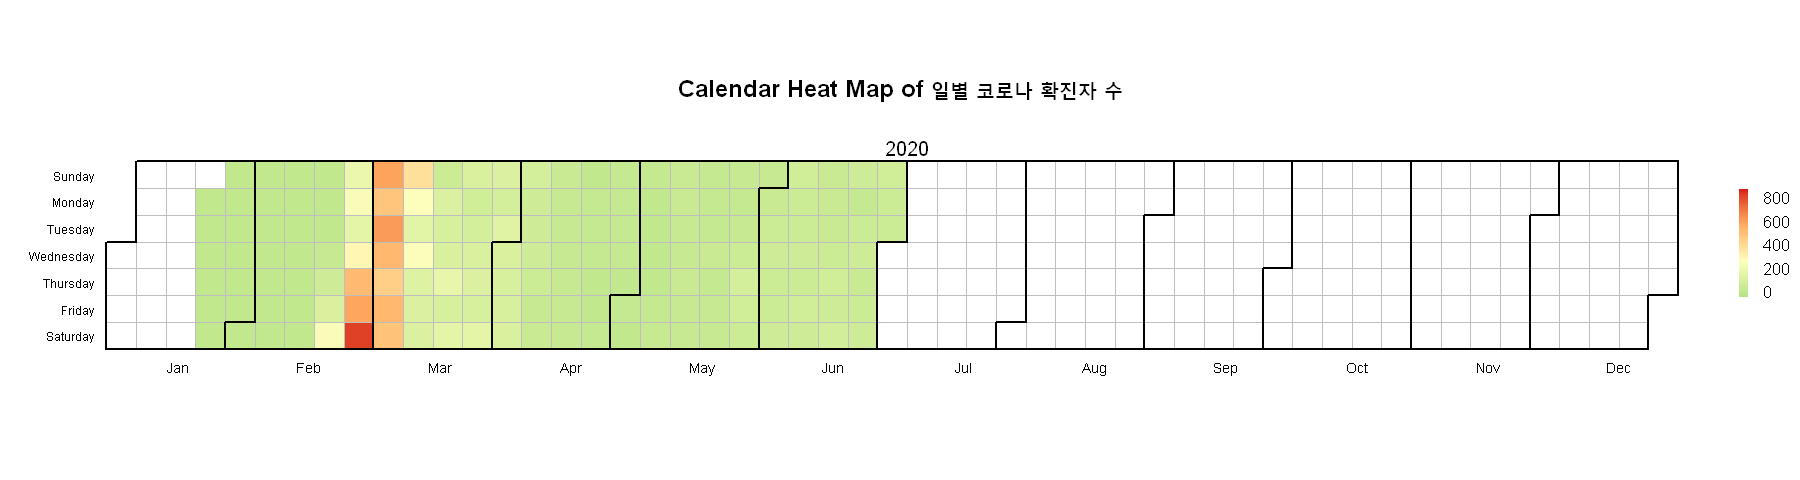

In [5]:
source("https://raw.githubusercontent.com/iascchen/VisHealth/master/R/calendarHeat.R")
#install.packages("chron")

library(repr)
# Change plot size to 15 x 4
options(repr.plot.width=15, repr.plot.height=4)
calendarHeat(dates = covidtime$date, values = confirmed_diff, color = "g2r", varname = "일별 코로나 확진자 수")

1월 20일 최초 국내 확진자를 시작으로 __2월 말 ~ 3월 초__ 동안에 많은 수의 확진자가 나왔으며 이후 점점 감소하면서 안정화가 되어가는 모습을 확인할 수 있습니다. 코로나가 가장 극심했던 시기 전후로 국민들의 이동 패턴에 어떠한 변화가 생겼는지 DSRC 데이터와 대중교통 이용 데이터를 통해 살펴보겠습니다.

### DSRC 데이터 시각화  
위에서 전처리한 일자별, 시간대별 DSRC 차량 수 데이터를 불러옵니다.

In [57]:
dsrc_count = fread("C:/Users/USER/dataset/dacon/DSRC원시자료/DSRC_count.csv")
head(dsrc_count)

date,time,count
<int>,<int>,<int>
20190101,7,62006
20190101,8,71474
20190101,9,108913
20190102,7,249633
20190102,8,187285
20190102,9,142170


calendarHeat 함수의 입력 형식에 맞도록 DSRC 데이터의 date 변수를 %Y-%m-%d 형식으로 변환해 주고, 7-9시 데이터를 한 번에 보기 위해 일자별로 그룹핑하여 합계를 구합니다.

In [58]:
dsrc_count$date = as.Date(as.character(dsrc_count$date), "%Y%m%d")
dsrc_count_bydate = dsrc_count[,.(count=sum(count)),by=date]
head(dsrc_count_bydate)

date,count
<date>,<int>
2019-01-01,242393
2019-01-02,579088
2019-01-03,570310
2019-01-04,564725
2019-01-05,392217
2019-01-06,240385


코로나 전후로 출근 첨두시(오전 7-10시)에 대해 어떠한 변화가 있었는지 코로나 데이터와 마찬가지로 **Calendar Heat Map**을 통해 시각화했습니다.

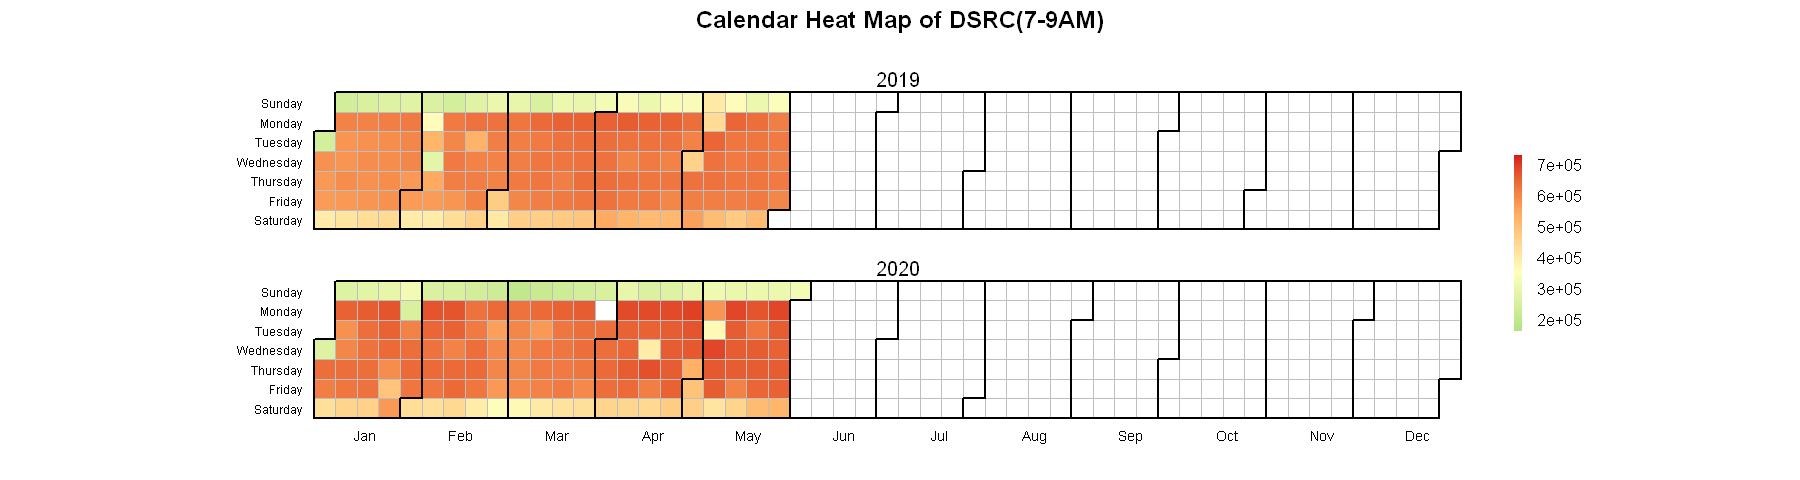

In [59]:
calendarHeat(dates = dsrc_count_bydate$date, values = dsrc_count_bydate$count, color = "g2r", varname = "DSRC(7-9AM)")

**코로나 확진자 급증 이후**로 DSRC 데이터가 **약간 감소**했다 **시간이 지남에 따라 지난해 보다 증가**하는 것을 확인할 수 있습니다. 이번에는 각 시간대별로 어떠한 변화가 있었는지 조금 더 자세하게 살펴보겠습니다.

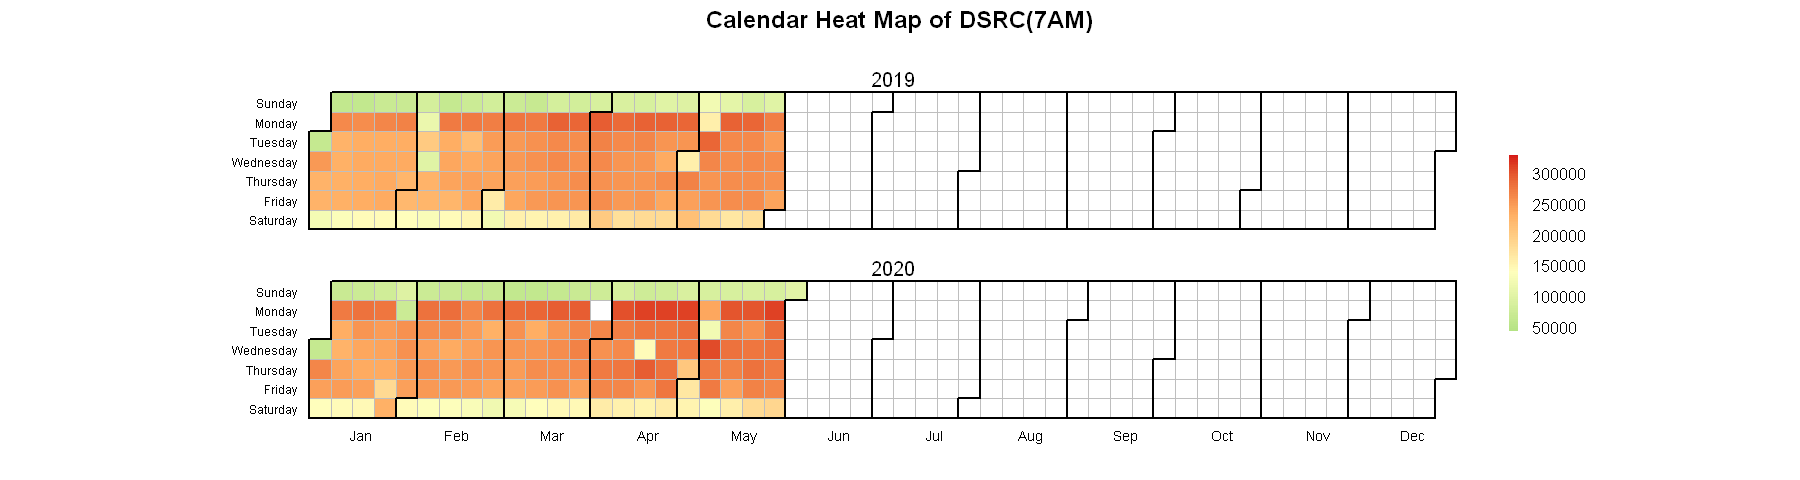

In [60]:
dsrc_count7 = dsrc_count[dsrc_count$time==7]
calendarHeat(dates = dsrc_count7$date, values = dsrc_count7$count, color = "g2r", varname = "DSRC(7AM)")

**7시 기준**으로는 코로나 확진자 수가 급증한 **2월말에서 3월초 사이에 변화는 미미**했고, **오히려 시간이 지남에 따라 전년도 대비 증가**하였습니다.

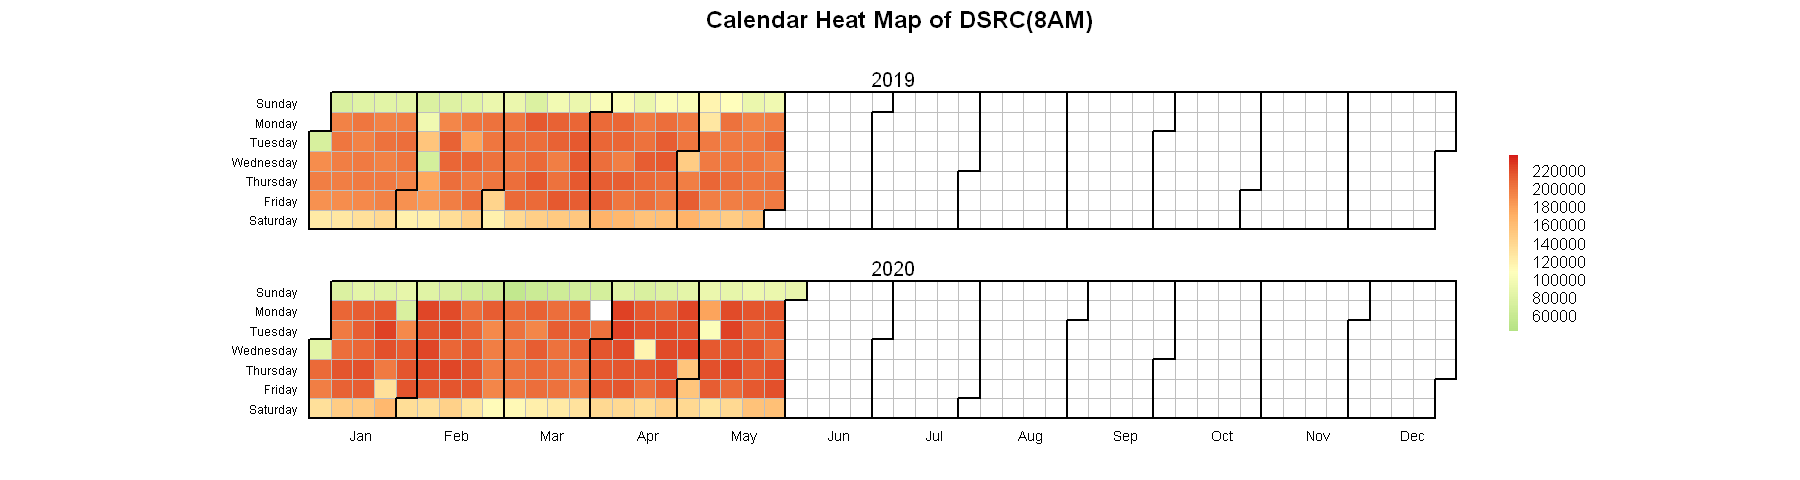

In [10]:
dsrc_count8 = dsrc_count[dsrc_count$time==8]
calendarHeat(dates = dsrc_count8$date, values = dsrc_count8$count, color = "g2r", varname = "DSRC(8AM)")

**8시 기준**으로는 **2월말에서 3월초에 조금 감소**하였으나, 7시와 마찬가지로 **시간이 지남에 따라 전년도보다 증가**한 것을 확인할 수 있습니다.

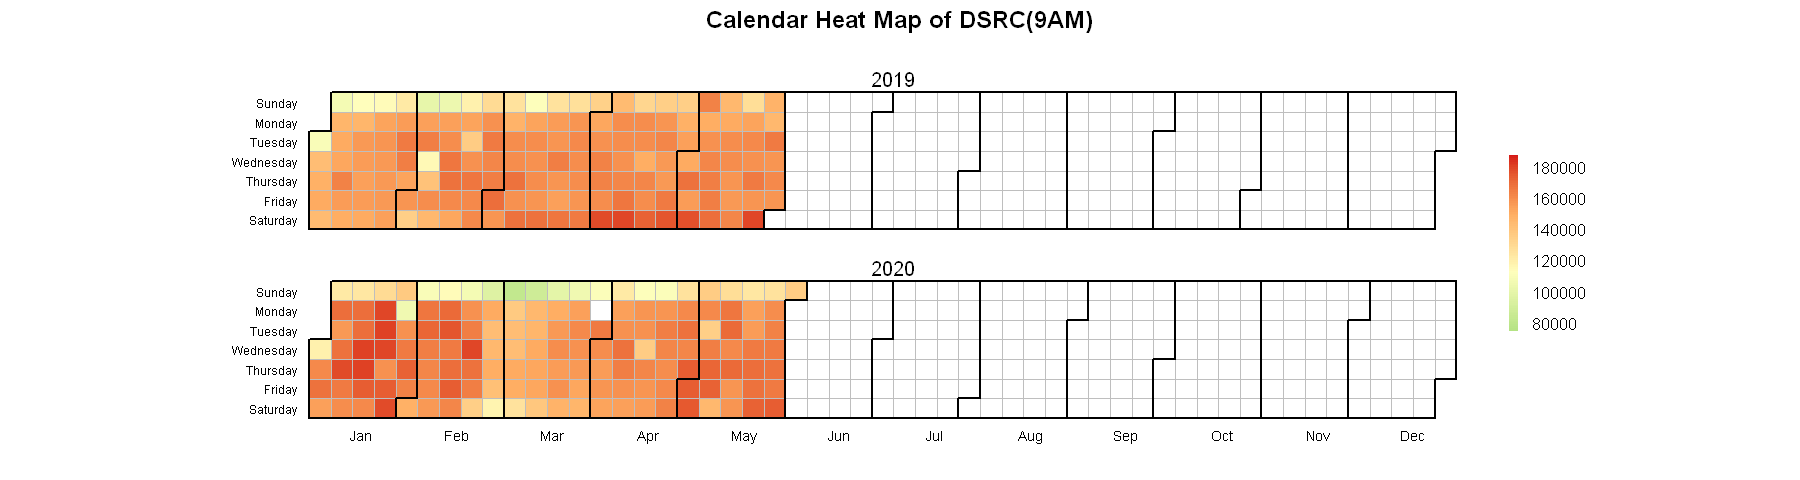

In [11]:
dsrc_count9 = dsrc_count[dsrc_count$time==9]
calendarHeat(dates = dsrc_count9$date, values = dsrc_count9$count, color = "g2r", varname = "DSRC(9AM)")

9시 기준으로는 조금 다른 패턴을 보입니다. **2월말에서 3월초에 눈에 띄게 감소**했으며 **시간이 지나면서 전년도와 비슷한 수준으로 증가**했습니다. **7-8시는 출근시간대**인 것을 감안할 때, **코로나 확진자 급증 이후 개인 이동 수단을 선호**하게 되어 자가용 차를 타고 다니는 사람이 늘어난 것으로 예상해 볼 수 있습니다. 일반적으로 출근 시간은 9시까지이므로 **9시 이후 데이터**는 **유연근무제를 시행하는 회사에 출근**하거나, **휴가를 통해 놀러가는 차량**으로 볼 수 있습니다. 유연 근무제를 시행하는 회사의 경우 코로나 확진자가 급증하자 **재택 근무**를 시행했을 수 있고([유연근무제 근로자 10명 중 4명은 재택근무 택했다](https://www.ajunews.com/view/20200623140331544)), 코로나 위험으로 외출을 자제하여 휴가를 통해 놀러가는 빈도 역시 줄어들었을 것이므로 이와 같은 결과가 나온 것이라 추측해볼 수 있습니다.

### 교통 카드 데이터 시각화  
이번에는 대중 교통 이용량에는 어떤 변화가 생겼는지 살펴보겠습니다.  
사용한 데이터는 교통수단별 이용량(DM_TFBY_USEV_SMY.dat) 파일입니다. ( CARD_0001.zip 파일에 있습니다.)
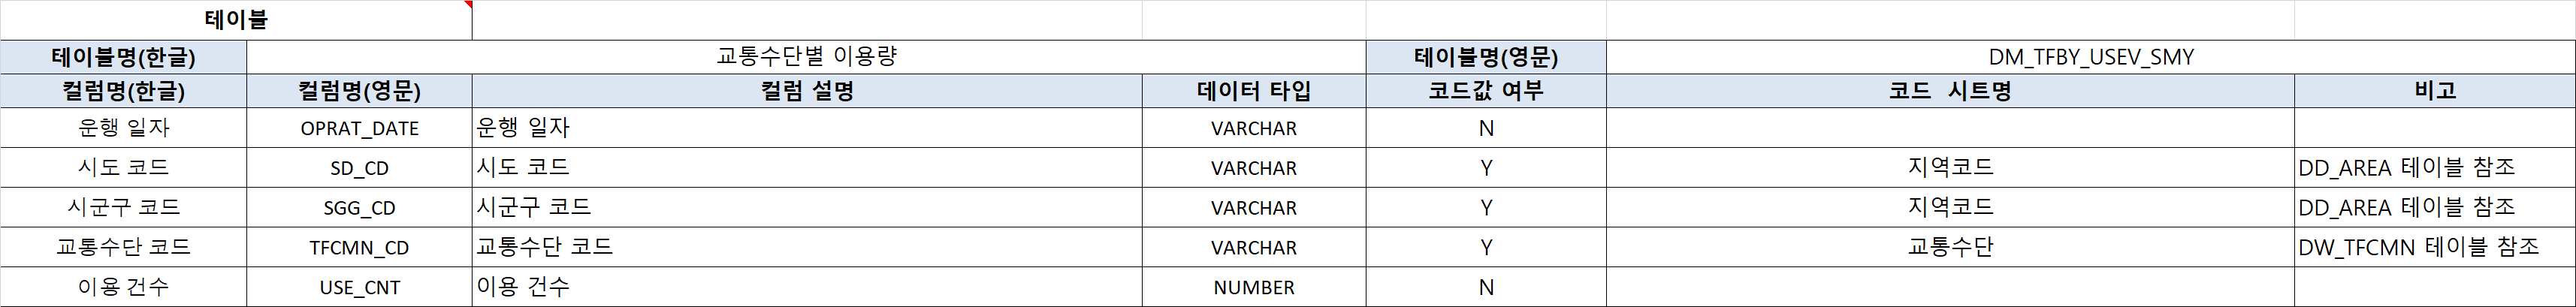  
해당 데이터를 통해 일별 대중교통 이용량을 파악할 수 있습니다.  
시도, 시군구 코드와 교통수단 코드는 아래와 같습니다.

In [12]:
dd_area = fread("C:/Users/USER/dataset/dacon/교통카드 대중교통 이용정보/DD_AREA.dat", sep='|', header = F, encoding = "UTF-8")
dw_tfcmn = fread("C:/Users/USER/dataset/dacon/교통카드 대중교통 이용정보/DW_TFCMN.dat", sep='|', header = F, encoding = "UTF-8")

In [13]:
dd_area

V1,V2,V3,V4,V5,V6,V7
<int>,<int>,<int>,<int64>,<chr>,<chr>,<chr>
1,11,11000,1100000000,서울특별시,서울특별시,서울특별시
2,11,11110,1111000000,서울특별시,종로구,종로구
3,11,11110,1111010100,서울특별시,종로구,청운동
3,11,11110,1111010200,서울특별시,종로구,신교동
3,11,11110,1111010300,서울특별시,종로구,궁정동
3,11,11110,1111010400,서울특별시,종로구,효자동
3,11,11110,1111010500,서울특별시,종로구,창성동
3,11,11110,1111010600,서울특별시,종로구,통의동
3,11,11110,1111010700,서울특별시,종로구,적선동


In [14]:
dw_tfcmn

V1,V2
<int>,<chr>
1,시내
2,시외
3,좌석
4,마을
5,간선
6,지선
7,광역
8,순환
9,농어촌버스


다음은 교통수단별 이용량 데이터입니다.

In [15]:
dm_tf = fread("C:/Users/USER/dataset/dacon/교통카드 대중교통 이용정보/DM_TFBY_USEV_SMY.dat", sep='|', header = F)
head(dm_tf)

V1,V2,V3,V4,V5
<int>,<chr>,<chr>,<chr>,<int>
20190101,11,11000,01,682
20190101,11,11000,04,75
20190101,11,11000,05,31
20190101,11,11000,07,62
20190101,11,11000,10,45
20190101,11,11000,11,1


변수명을 엑셀파일을 참고하여 변경해주고, DSRC 데이터와 마찬가지로 date 포맷을 변경해줍니다.  
지역별로 일별 대중교통 이용량을 분석하기 위해 시도 코드와 운행 일자로 group by 하여 USE_CNT의 합을 계산합니다.

In [16]:
colnames(dm_tf) =  c('OPRAT_DATE', 'SD_CD', 'SGG_CD', 'TFCMN_CD', 'USE_CNT')
dm_tf$OPRAT_DATE = as.Date(as.character(dm_tf$OPRAT_DATE), "%Y%m%d")
new_dm_tf = dm_tf[, sum(USE_CNT), by=c("OPRAT_DATE", "SD_CD")]
head(new_dm_tf)

OPRAT_DATE,SD_CD,V1
<date>,<chr>,<int>
2019-01-01,11,5137990
2019-01-01,26,1304078
2019-01-01,27,465545
2019-01-01,28,741922
2019-01-01,29,175491
2019-01-01,30,239090


**서울특별시(시도코드 11)**의 대중교통 이용 패턴을 살펴보겠습니다.

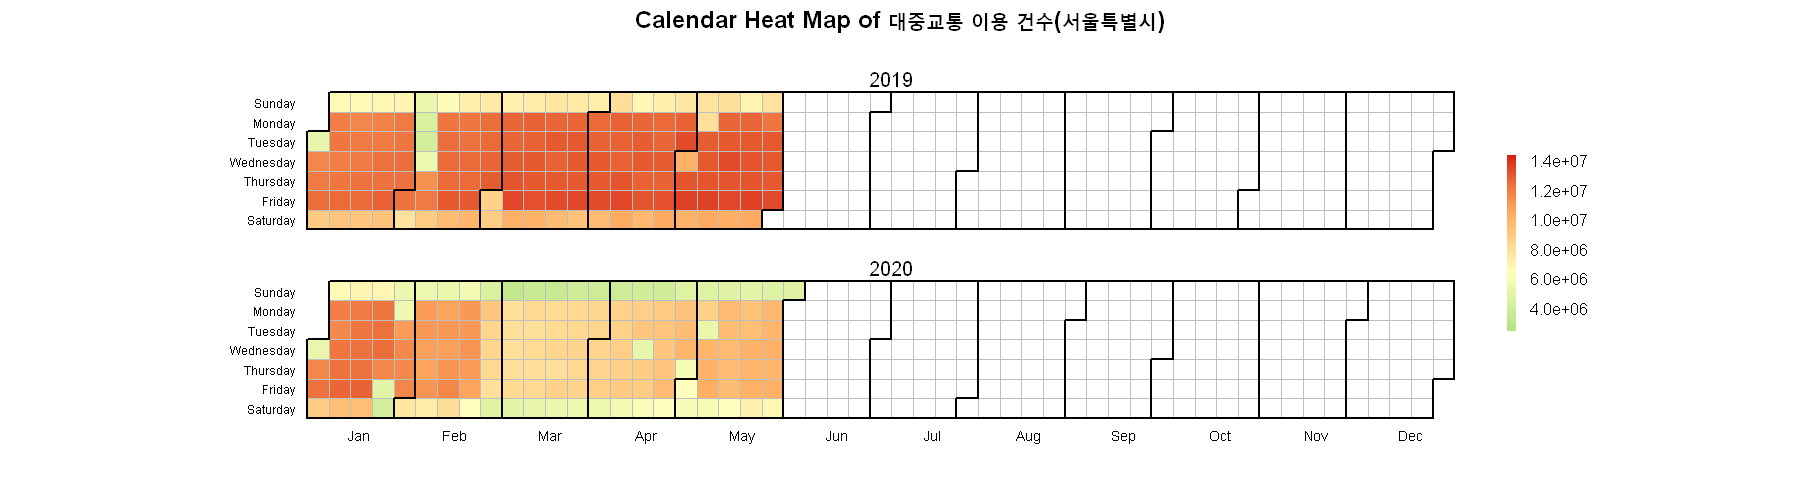

In [17]:
new_dm_tf_SEOUL = new_dm_tf[new_dm_tf$SD_CD == 11]
calendarHeat(dates = new_dm_tf_SEOUL$OPRAT_DATE, values = new_dm_tf_SEOUL$V1, color = "g2r", varname = "대중교통 이용 건수(서울특별시)")

아직은 국내 확진자가 나오지 않은 1월 초와 비교했을 때, 첫 확진자가 발생한 1월 20일 이후에 1차적으로 대중교통 이용 수가 약간 감소한 것을 볼 수 있습니다.
이후 코로나 확진자가 가장 많이 나온 2월말에 대중교통 이용량이 눈에 띄게 감소하였습니다.
기업들이 재택근무를 시작하기도 하고, 불안함에 외출을 자제한 영향도 있겠지만, 타인과 밀집하여 이동할 수 밖에 없는 대중 교통의 특성이 반영된 것으로 보입니다.
확진자 추세가 안정화되는 4월 말부터 다시 조금씩 이용량이 증가하는 것도 확인할 수 있습니다.  
**마스크 미착용시 대중교통 이용 불가 정책이 5월 26일에 시행 됐는데, 제공되는 데이터는 5월 말까지라 그 이후에 어떠한 변화가 있었는지도 볼 수 있었으면 좋았을 것 같습니다.** 모두가 마스크를 착용했을 때 감염율이 대폭 낮아지니 국민들이 조금이라도 더 안심하고 대중교통을 이용해서, 이용 수가 더 늘어나지 않았을까 조심스럽게 예측해 봅니다.(물론 당장 눈에 보이는 5월 26-31까지는 별다른 차이가 없지만요..)

이번에는 이동 수단별 이용량에 대해 패턴을 살펴보겠습니다.

In [18]:
new_dm_tf2 = dm_tf[, sum(USE_CNT), by=c("OPRAT_DATE", "TFCMN_CD")]
head(new_dm_tf2)

OPRAT_DATE,TFCMN_CD,V1
<date>,<chr>,<int>
2019-01-01,01,3348926
2019-01-01,04,1182935
2019-01-01,05,1368309
2019-01-01,07,250770
2019-01-01,10,18566
2019-01-01,11,4490965


그 중 특별한 패턴을 보이는 **시외버스(TFCMN_CD 02)**와 **공항버스(TFCMN_CD 10)**에 대해 살펴보겠습니다.

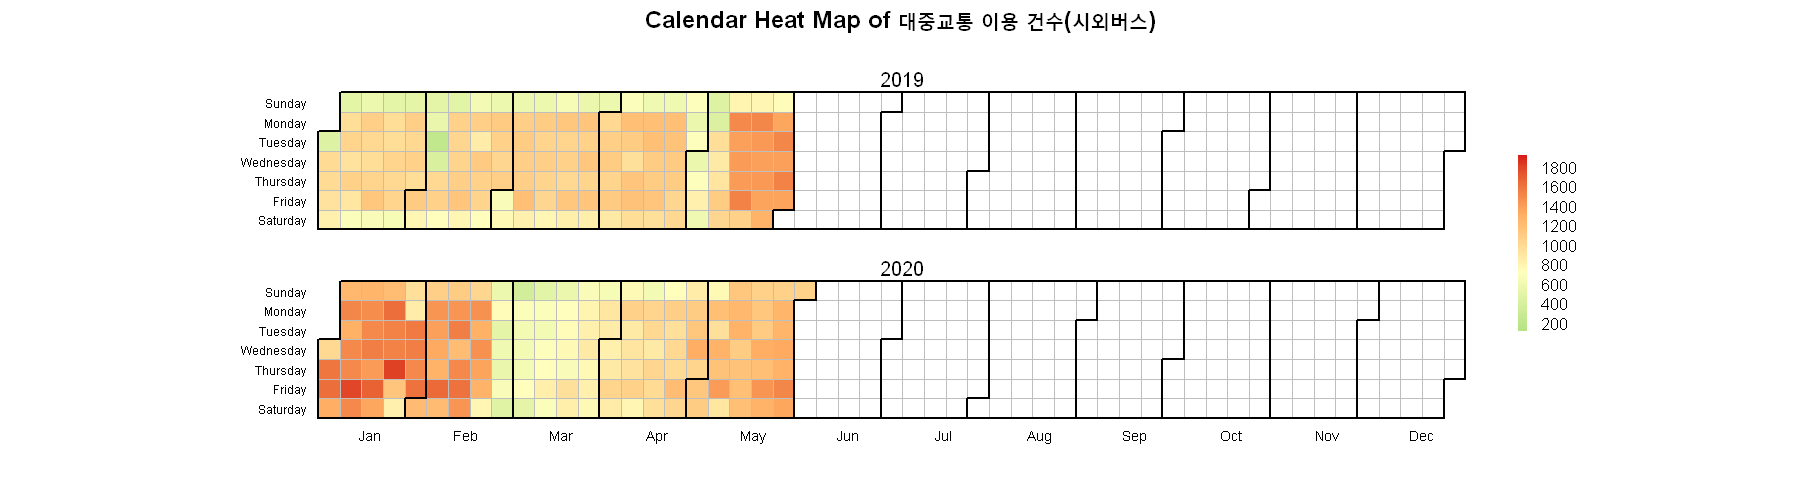

In [19]:
new_dm_tf2_SEOUL_TFCNM2 = new_dm_tf2[new_dm_tf2$TFCMN_CD=="02"]
calendarHeat(dates = new_dm_tf2_SEOUL_TFCNM2$OPRAT_DATE, values = new_dm_tf2_SEOUL_TFCNM2$V1, color = "g2r", varname = "대중교통 이용 건수(시외버스)")

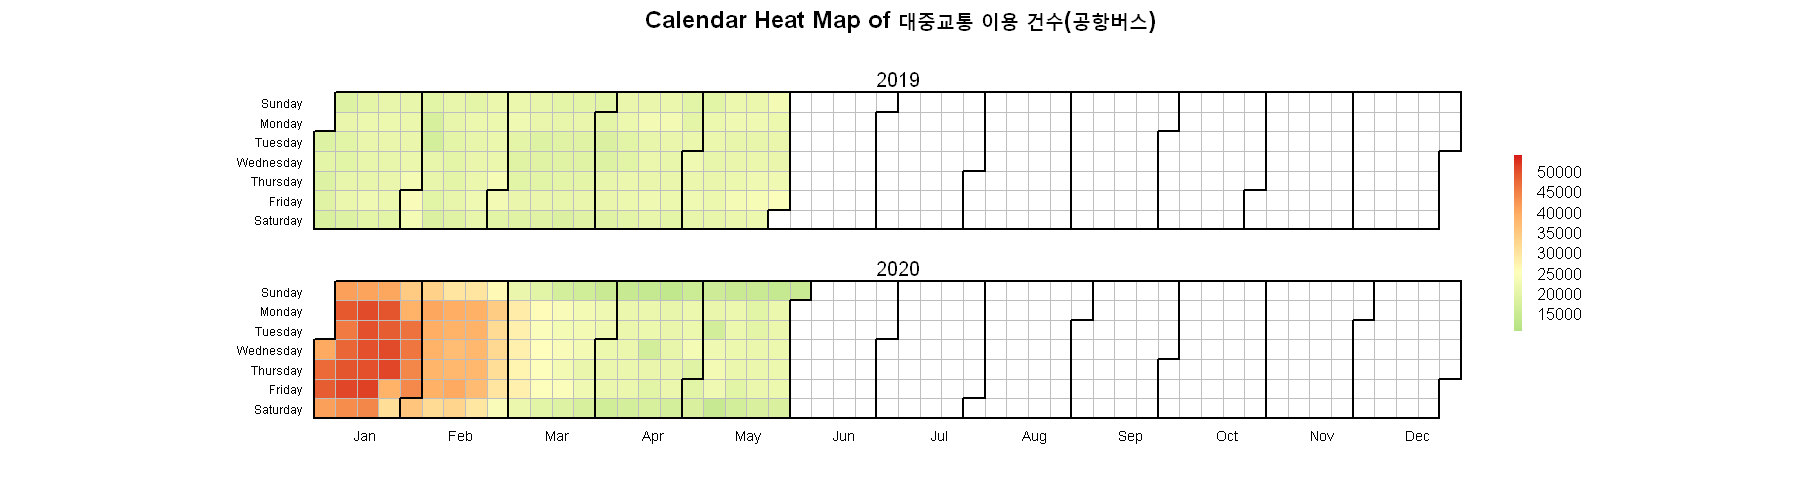

In [20]:
new_dm_tf2_SEOUL_TFCNM2 = new_dm_tf2[new_dm_tf2$TFCMN_CD=="10"]
calendarHeat(dates = new_dm_tf2_SEOUL_TFCNM2$OPRAT_DATE, values = new_dm_tf2_SEOUL_TFCNM2$V1, color = "g2r", varname = "대중교통 이용 건수(공항버스)")

시외버스와 공항버스 모두 코로나 확진자 수가 급증한 시기부터 급격하게 감소한 것을 확인할 수 있으나, 2020년 1,2월에 이용 건수가 집중되어 있는 것은 조금 더 살펴볼 필요가 있는 것 같습니다.

데이터를 조금 더 자세히 보기 위해 **시도별** 시외버스 및 공항버스 이용 건수를 시각화 했습니다.

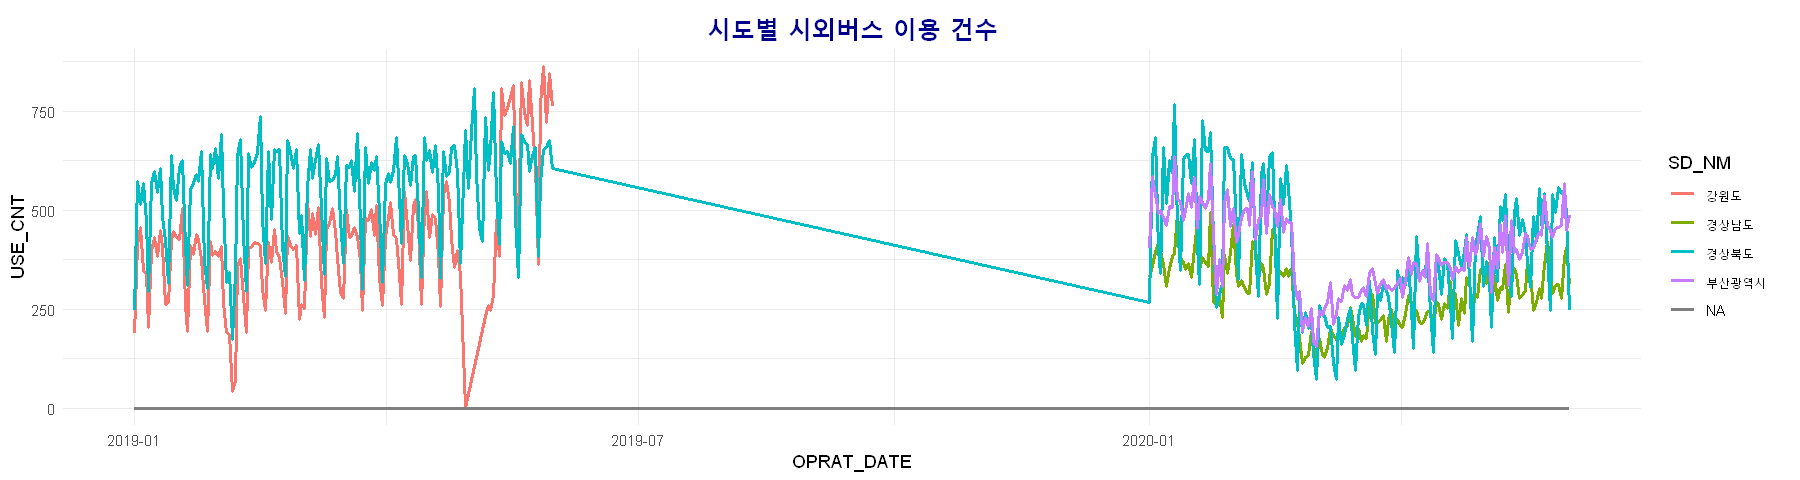

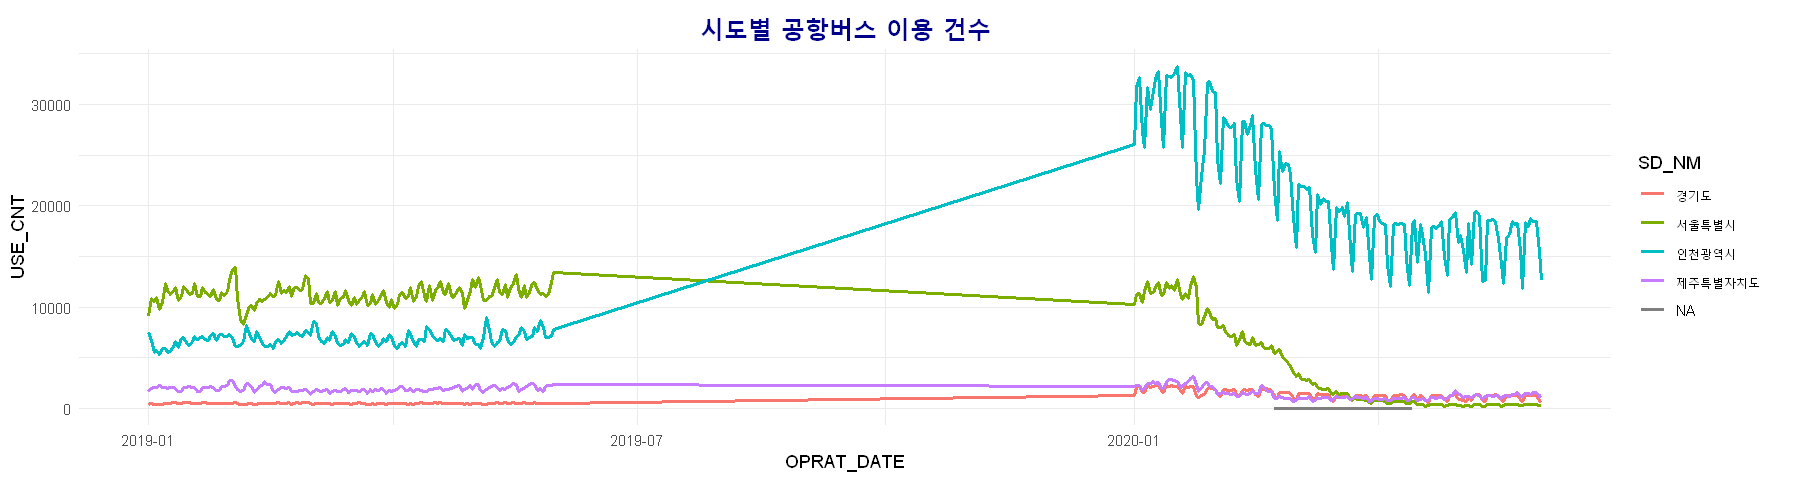

In [21]:
dm_tf = fread("C:/Users/USER/dataset/dacon/교통카드 대중교통 이용정보/DM_TFBY_USEV_SMY.dat", sep='|', header = F)
colnames(dm_tf) =  c('OPRAT_DATE', 'SD_CD', 'SGG_CD', 'TFCMN_CD', 'USE_CNT')

dd_area = fread("C:/Users/USER/dataset/dacon/교통카드 대중교통 이용정보/DD_AREA.dat", sep='|', header = F, encoding="UTF-8")
colnames(dd_area) = c("AREA_GB", "SD_CD", "SGG_CD", "USE_AREA_CD", "SD_NM", "SGG_NM", "EMD_NM")

dm_tf$SD_NM = dd_area$SD_NM[match(dm_tf$SD_CD, dd_area$SD_CD)] # 시도 코드를 시도 이름으로 매칭하여 컬럼에 추가

dm_tf$OPRAT_DATE = as.Date(as.character(dm_tf$OPRAT_DATE), "%Y%m%d")
tfcmn02 = dm_tf[dm_tf$TFCMN_CD=="02"]
tfcmn10 = dm_tf[dm_tf$TFCMN_CD==10]
tfcmn02 = tfcmn02[,.(USE_CNT=sum(USE_CNT)),by=list(OPRAT_DATE, SD_NM)]
tfcmn10 = tfcmn10[,.(USE_CNT=sum(USE_CNT)),by=list(OPRAT_DATE, SD_NM)]

library(ggplot2)
ggplot(tfcmn02, aes(x = OPRAT_DATE, y = USE_CNT)) + 
  ggtitle("시도별 시외버스 이용 건수") +
  geom_line(aes(color = SD_NM), size = 1) +
  theme_minimal() + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 20, color = "darkblue"))
ggplot(tfcmn10, aes(x = OPRAT_DATE, y = USE_CNT)) + 
  ggtitle("시도별 공항버스 이용 건수") +
  geom_line(aes(color = SD_NM), size = 1) +
  theme_minimal() + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 20, color = "darkblue"))

중간에 선이 길게 이어지는 부분은 해당 구간에 데이터가 없어서 생긴 것입니다. **제공된 데이터는 2019년 1-5월, 2020년 1-5월**에 대한 데이터입니다.

**시외버스**의 경우는 **2019년**에는 **강원도**와 **경상북도** 데이터만 있고, **2020년**에는 강원도 데이터가 사라지고, **경상북도, 부산광역시, 경산남도** 데이터가 포함되어 있습니다. 2019년과 2020년 데이터가 모두 있는 경상북도를 기준으로 본다면 1,2월 데이터가 작년과는 크게 차이가 없는 것을 확인할 수 있고, 2월말에 이용 수가 급감하는 것을 확인할 수 있습니다. **이를 통해 캘린더 히트맵에서 보인 1,2월에 이용 건수가 집중되어 있는 것은 데이터 수집 관련된 이슈로 보여집니다.**

**공항버스**의 경우 인천광역시의 1월 이용 건수가 작년과 비교했을 때 3배 이상 증가한 것을 확인할 수 있습니다. 다른 시는 작년과 1월과 비교했을 때 큰 차이가 없습니다. 시외버스와 마찬가지로 데이터가 수집 된 지역이 다른지 확인하기 위해 **인천광역시**의 데이터만 가지고 **구별** 공항버스 이용 건수를 시각화했습니다.

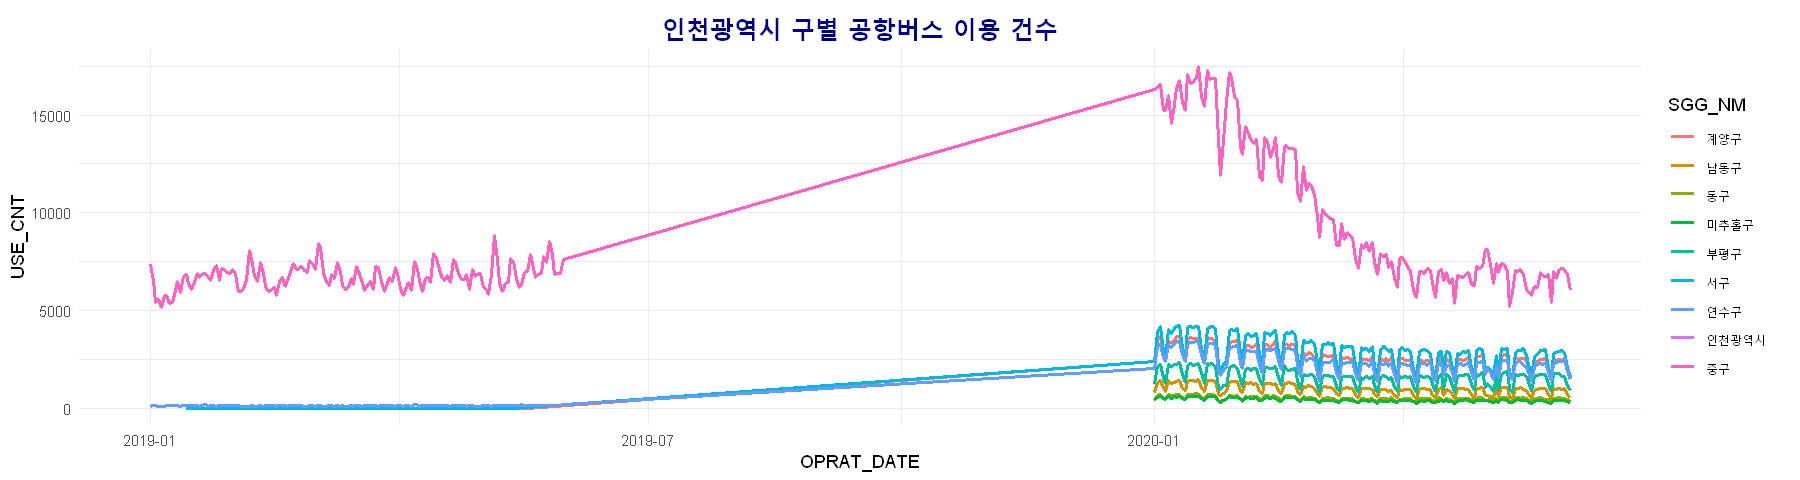

In [22]:
dm_tf$SGG_NM = dd_area$SGG_NM[match(dm_tf$SGG_CD, dd_area$SGG_CD)] # 시군구 코드를 시군구 이름으로 매칭하여 컬럼에 추가

tfcmn10 = dm_tf[dm_tf$TFCMN_CD==10]
tfcmn10 = tfcmn10[,.(USE_CNT=sum(USE_CNT)),by=list(OPRAT_DATE, SD_NM, SGG_NM)]

ggplot(tfcmn10[tfcmn10$SD_NM=='인천광역시'], aes(x = OPRAT_DATE, y = USE_CNT)) + 
  ggtitle("인천광역시 구별 공항버스 이용 건수") +
  geom_line(aes(color = SGG_NM), size = 1) +
  theme_minimal() + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 20, color = "darkblue"))

몇몇 구를 보면 2019년에 없던 데이터가 생긴 구도 있지만, 중구 데이터가 약 3배 늘은 것이 가장 먼저 보입니다. 중구는 인천국제공항이 있는 곳입니다. 혹시 작년 대비 해외여행객이 많이 늘은 것이 아닌가 해서 공항 이용자 수 통계를 찾아보았습니다. [한국공항공사 - 공항별 전년대비 통계](https://www.airport.co.kr/www/extra/stats/airportYearStats/layOut.do?menuId=398)

기준 연도를 2020년, 시작 월과 종료 월을 1월, 공항 구분을 인천으로 설정했습니다. 전년대비 통계는 아래와 같습니다.

<img src="https://drive.google.com/uc?export=download&id=16O69I0h_Udfx-IRGfwX0sYLnv6yocRvX" style="width:100%">

위의 표를 보면 여객 수는 2019년보다 0.9% 밖에 증가하지 않았습니다. 즉, 여행객 수가 늘어서 공항버스 이용 건수가 3배나 늘었다고 볼 수는 없는 것 같아 보입니다. 기사를 살펴봐도 이러한 상황을 설명하기는 어렵습니다. [인천공항 5월 이용객 13만명 ‘역대 최저’](http://news.khan.co.kr/kh_news/khan_art_view.html?art_id=202006011425011)

<img src="https://drive.google.com/uc?export=download&id=1SScWToAE36mR9N4HRp5R3Cz0ZirtBI0Q" style="width: 60%;"/>

데이터가 제공되는 기간인 올해 1~5월과 지난해 같은 기간을 비교했을 때, 누적 이용객이 64.2%나 감소한 반면, 공항버스 이용 건수는 늘었다는 것은 이해가 되지 않습니다. 5월 기준으로 인천공항 이용객은 지난해 대비 무려 97.6%나 감소했음에도 불구하고 2019년과 2020년의 5월 공항버스 이용량을 보면 2020년이 오히려 2배 이상 많은 것을 확인할 수 있습니다. *데이터를 취합하는 과정에서 2020년 인천광역시 공항버스 데이터가 중복해서 여러 번 입력된 것이 아닌가하는 생각이 듭니다.*

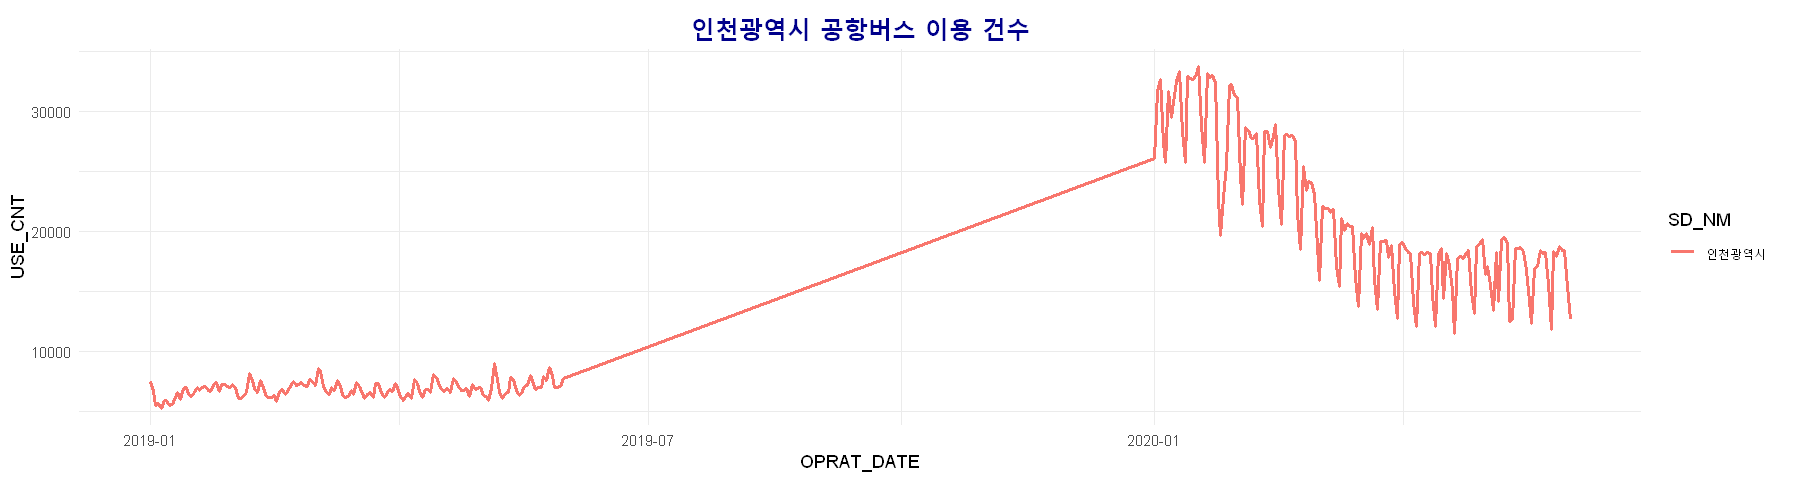

In [23]:
tfcmn10_ICN = tfcmn10[tfcmn10$SD_NM=='인천광역시',.(USE_CNT=sum(USE_CNT)),by=list(OPRAT_DATE, SD_NM)]
ggplot(tfcmn10_ICN, aes(x = OPRAT_DATE, y = USE_CNT)) + 
  ggtitle("인천광역시 공항버스 이용 건수") +
  geom_line(aes(color = SD_NM), size = 1) +
  theme_minimal() + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 20, color = "darkblue"))

어떠한 이유로 인해 2020년 데이터의 양이 급증했지만 코로나가 극심했던 시기부터 이용 건수는 급격하게 감소한다는 사실은 변하지 않습니다.  

특이한 패턴이 나온 이유를 살펴보다 잠시 딴 길로 새긴 했지만, 결론은 코로나로 인해 대중교통 이용량이 감소했다는 것입니다.

### KT 유동인구 데이터 시각화

코로나로 인해 **외출이 감소하면서 대중교통 이용이 줄은 것인지**, **실제로 이용 빈도가 줄었는지** 확인하기 위해 **KT 유동인구 데이터**와 대중교통 이용건수 데이터를 함께 살펴보겠습니다.

<img src="https://drive.google.com/uc?export=download&id=1pjuLeuDKJgXhXv42jEelJNIgwgdhGvu4" style="width:100%">

In [24]:
fpopl_2019 = fread("C:/Users/USER/dataset/dacon/KT유동인구데이터/fpopl_2019/fpopl_2019.csv")
fpopl_2020 = fread("C:/Users/USER/dataset/dacon/KT유동인구데이터/fpopl_2020/fpopl_2020.csv")
fpopl_2019$base_ymd = as.Date(as.character(fpopl_2019$base_ymd), "%Y%m%d")
fpopl_2020$base_ymd = as.Date(as.character(fpopl_2020$base_ymd), "%Y%m%d")
fpopl_2019$SD_CD = substr(fpopl_2019$adstrd_code, 1, 2)
fpopl_2020$SD_CD = substr(fpopl_2020$adstrd_code, 1, 2)
table(fpopl_2019$SD_CD)
table(fpopl_2020$SD_CD)


      11 
25391659 


      11 
25737734 

행정동 코드를 보니 앞에 2자리가 위에서 사용한 시도 코드인 것 같아서 시도별로 몇 개씩 데이터가 있는지 먼저 확인해봤습니다. 행정동 코드 상세 테이블을 참고해보니 맨 앞이 11로 시작하는 것은 대중교통 데이터와 마찬가지로 서울특별시에 대한 코드였습니다. 따라서 제공받은 **KT 유동인구 데이터**는 **서울시**에 대한 데이터인 것을 확인할 수 있습니다.  
일자별로 유동인구 수를 보기 위해 데이터를 처리하고 Calendar Heat Map을 그려보았습니다.

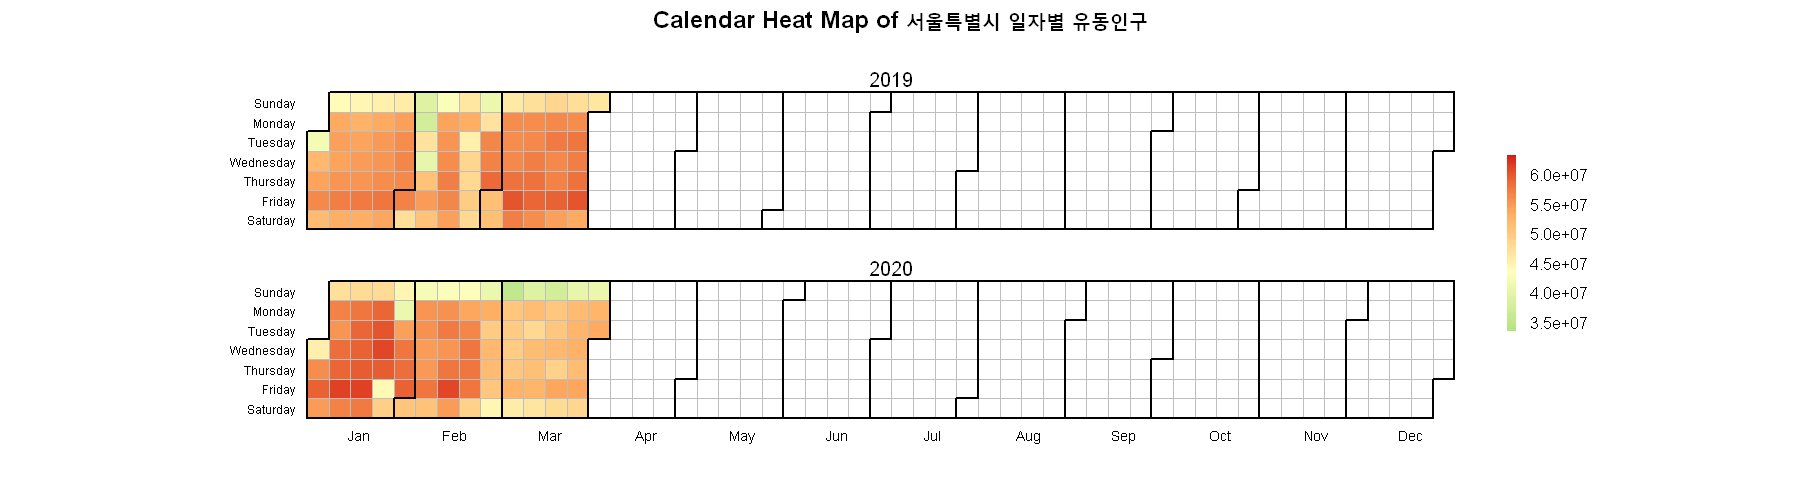

In [25]:
fpopl_2019_byDate = fpopl_2019[,.(popltn_cascnt=sum(popltn_cascnt)),by=list(date = base_ymd)]
fpopl_2020_byDate = fpopl_2020[,.(popltn_cascnt=sum(popltn_cascnt)),by=list(date = base_ymd)]

fpopl_total = rbind(fpopl_2019_byDate, fpopl_2020_byDate)

calendarHeat(dates = fpopl_total$date, values = fpopl_total$popltn_cascnt, color = "g2r", varname = "서울특별시 일자별 유동인구", )

유동인구 역시 코로나가 확산한 2월말부터 급감한 것을 확인할 수 있습니다. 여기까지 본다면 유동인구가 줄어서 대중교통 이용량이 줄었다고 생각할 수도 있기 때문에, **유동인구 대비 대중교통 이용량**을 살펴볼 필요가 있습니다.

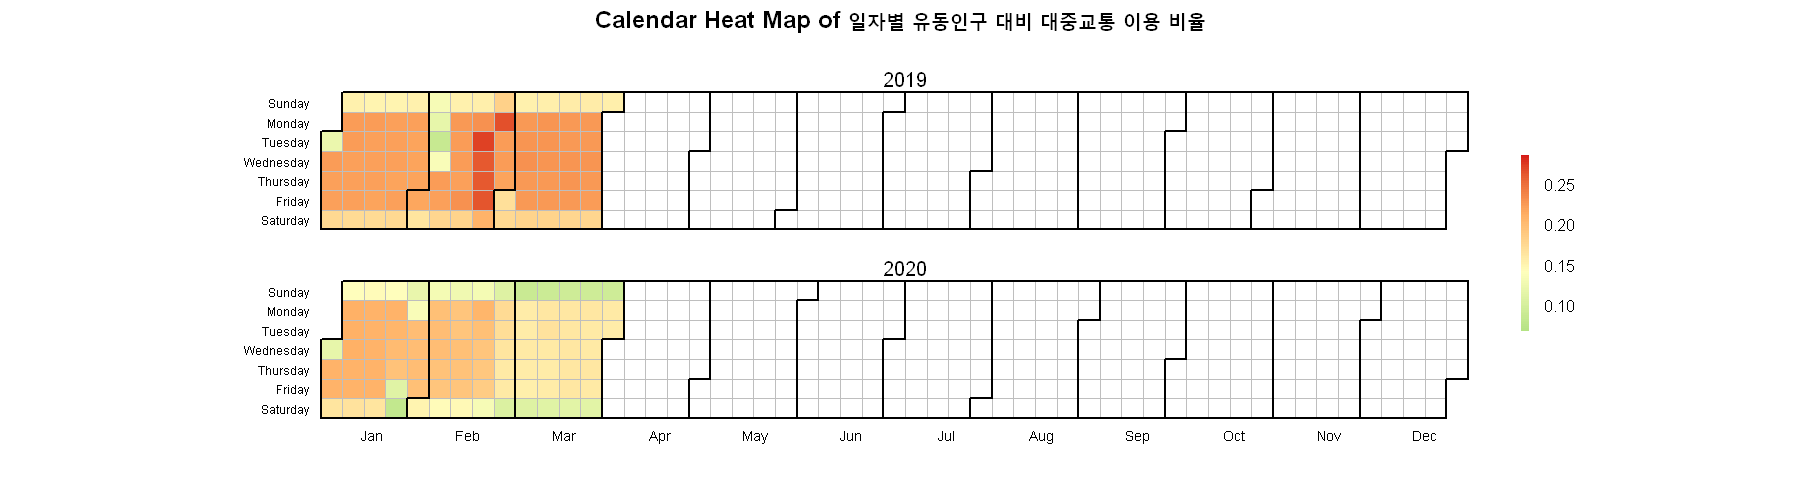

In [26]:
dm_tf_SEOUL = dm_tf[dm_tf$SD_CD==11] # 서울시 대중교통 이용 건수
dm_tf_SEOUL_byDate = dm_tf_SEOUL[,.(USE_CNT=sum(USE_CNT)), by=list(date = OPRAT_DATE)]

merged_dm_fpopl = merge(dm_tf_SEOUL_byDate, fpopl_total)
merged_dm_fpopl$ratio = merged_dm_fpopl$USE_CNT / merged_dm_fpopl$popltn_cascnt # 유동인구 대비 대중교통 이용 비율 계산

calendarHeat(dates = merged_dm_fpopl$date, values = merged_dm_fpopl$ratio, color = "g2r", varname = "일자별 유동인구 대비 대중교통 이용 비율", )

적당한 데이터 처리와 계산을 통해 일별로 유동인구 대비 대중교통 이용 비율을 계산해서 시각화 한 결과, **대중교통 이용 비율 또한 코로나 확산 시기에 급감한 것을 확인할 수 있습니다.** 따라서 코로나로 인해 외출이 감소했을 뿐만 아니라, 외출시에도 대중교통을 이전보다 덜 이용하게 되었다고 볼 수 있습니다.

그에 비해 DSRC 데이터는 시간대별로 다르지만, 눈에 띄게 감소하진 않았으며 오히려 시간이 지남에 따라 전년도보다 증가한 것을 확인할 수 있었습니다. 즉 **사람들은 안전한 이동을 위해 많은 사람들이 이용하는 대중교통 보다 자가용 차를 선호**하게 되었고, 이는 **도로에 차가 많아지게 해 교통 혼잡을 불러 일으킬 수 있습니다.**

### 서울시 공공 자전거 데이터 시각화

앞서 분석한 내용을 통해 국민들은 코로나의 위험으로부터 벗어나기 위해 대중교통 이용을 꺼려하고 상대적으로 안전한 자차를 이용하는 것을 확인했습니다. 대중교통 이용의 감소는 도로에 차를 더욱 많게 하고, 이는 교통 혼잡을 불러 일으킬 수 있습니다. 이를 해결하기 위한 대체 이동 수단이 필요합니다. 최근 국내 및 해외에서는 코로나의 여파로 자전거의 판매량이 급증했다고 합니다([두 바퀴로 가는 지구촌… 코로나19에 ‘자전거 열풍’](http://m.cnews.co.kr/m_home/view.jsp?idxno=202006151709031330918)).  코로나 때문에 실내 운동을 하지 못하게 되자, 개인 이동수단이면서 동시에 운동까지 되는 자전거를 찾게 된 것입니다. 실제로 자전거 이용량이 많이 늘었는지 서울시 공공 자전거인 따릉이 데이터를 통해 살펴보겠습니다.

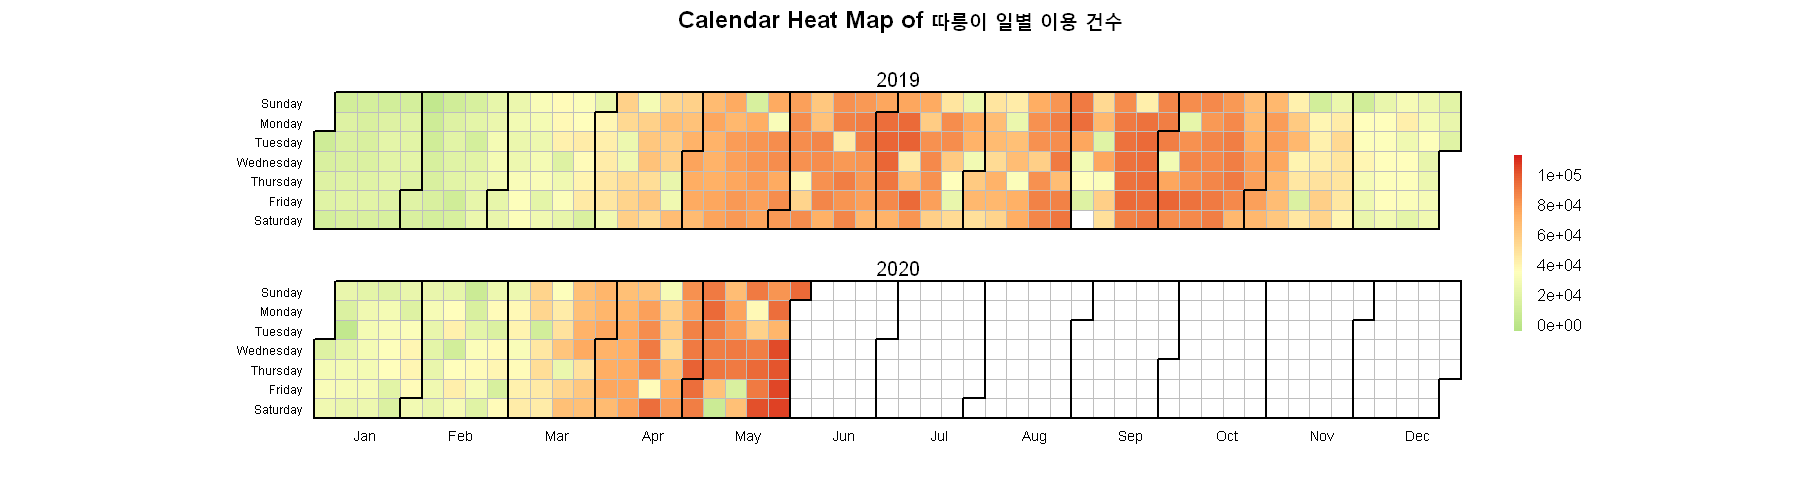

In [27]:
seoul_bike = fread("C:/Users/USER/dataset/dacon/따릉이/일일 대여건수.csv")
seoul_bike$date = as.Date(as.character(seoul_bike$date), "%Y.%m.%d")
seoul_bike$count = as.integer(gsub(',', '', seoul_bike$count))
calendarHeat(dates = seoul_bike$date, values = seoul_bike$count, color = "g2r", varname = "따릉이 일별 이용 건수")

일별 따릉이 이용 건수를 살펴본 결과 실제로 전년 대비 왼쪽으로 약간 쉬프트 된 것을 확인할 수 있습니다. 코로나 확진자가 증가한 이후에 대중교통 대신 따릉이를 이용 수단으로 사용한 것으로 보여집니다. 따릉이 일평균 이용자 수가 매년 증가하는 추세라서 ([서울시, 따릉이 4년…누적 대여 3천만 건 돌파](https://www.mk.co.kr/news/society/view/2019/11/902106/)) 이런 결과가 나온 것일 수도 있습니다. 이를 확인하기 위해 **일별 신규 가입자 수**를 분석해 보았습니다.

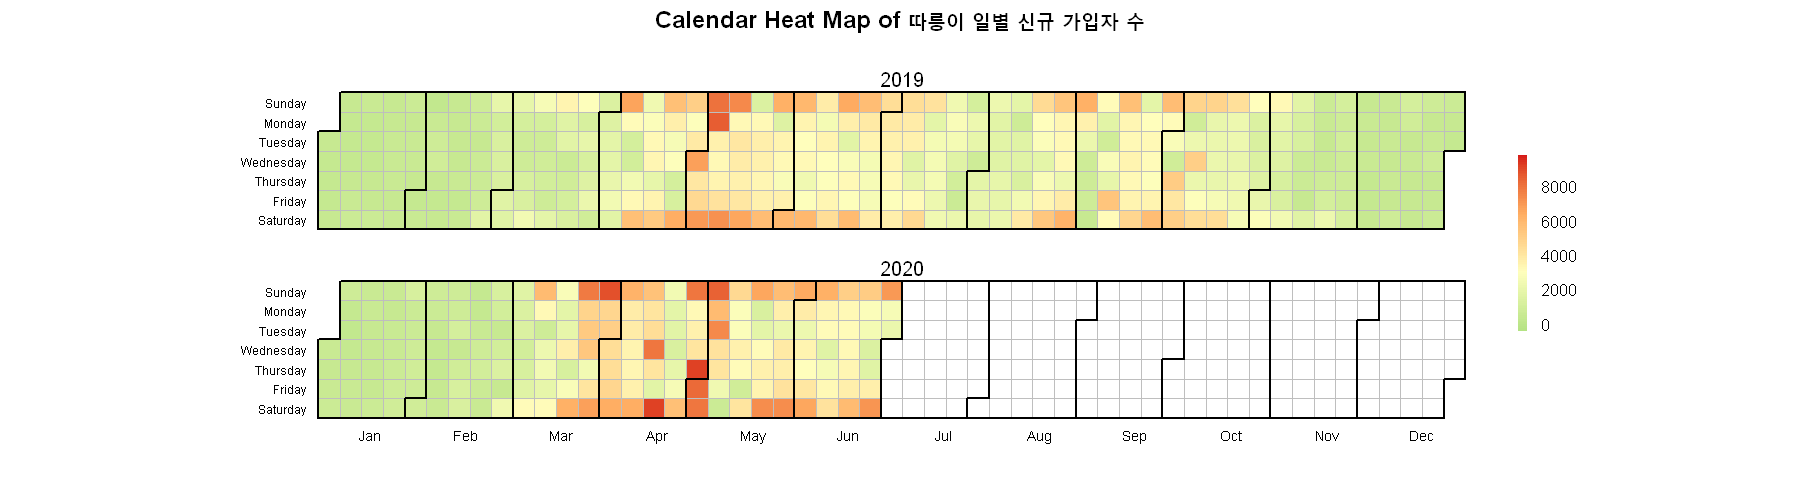

In [28]:
seoul_bike_new = fread("C:/Users/USER/dataset/dacon/따릉이/신규가입자 정보(일별).csv", encoding="UTF-8")
seoul_bike_new_bydate = seoul_bike_new[,.('가입 수'=sum(`가입 수`)),by=list(`가입일자`)]
calendarHeat(dates = seoul_bike_new_bydate$`가입일자`, values = seoul_bike_new_bydate$`가입 수`, color = "g2r", varname = "따릉이 일별 신규 가입자 수")

그 결과 일별 이용 건수와 마찬가지로 전년 대비 왼쪽으로 쉬프트 된 것을 볼 수 있습니다. 저도 따릉이 월정액권을 구매해서 출퇴근했던 이용자로써, 날씨가 너무 춥거나 너무 더울 땐 월정액권을 구매하지 않고 지하철을 이용했었습니다. **2019년** 데이터 역시 조금씩 **따뜻해지는 4월부터 이용 건수와 신규 가입자 수가 증가**한 반면, **2020년**은 보다 빠르게 **3월 중순부터 증가**한 것을 볼 수 있습니다. 혹시 올해가 지난 해보다 날씨가 빨리 따뜻해졌는지를 살펴볼 필요가 있습니다.

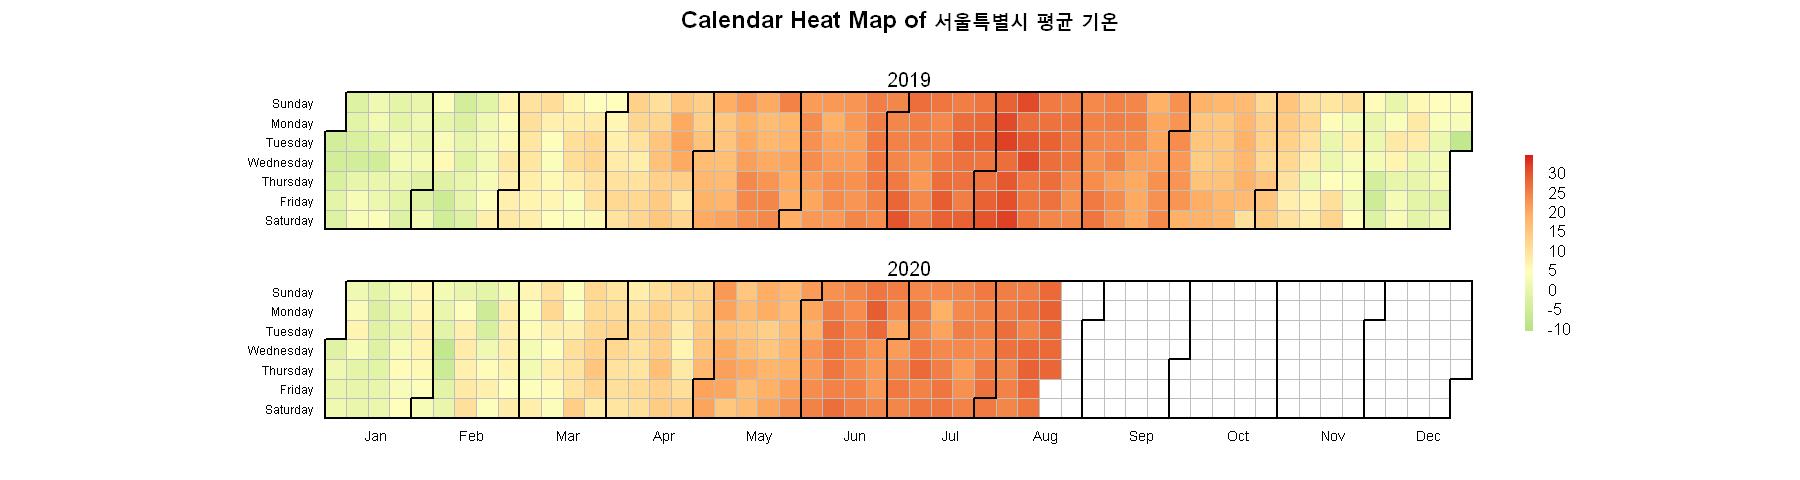

In [29]:
temp = fread("C:/Users/USER/dataset/dacon/날씨데이터/평균기온.csv", encoding="UTF-8")
colnames(temp) = c('date', 'avg_temp')
temp$year = substr(temp$date,1,4)
calendarHeat(dates = temp$date, values = temp$avg_temp, color = "g2r", varname = "서울특별시 평균 기온", )

3월 기준으로 평균 기온은 전년도와 크게 다를게 없어 보입니다. 그렇다면 혹시 2019년 3월에 비가 많이 온 것은 아닐지, 강수량 데이터를 통해 확인해보겠습니다.

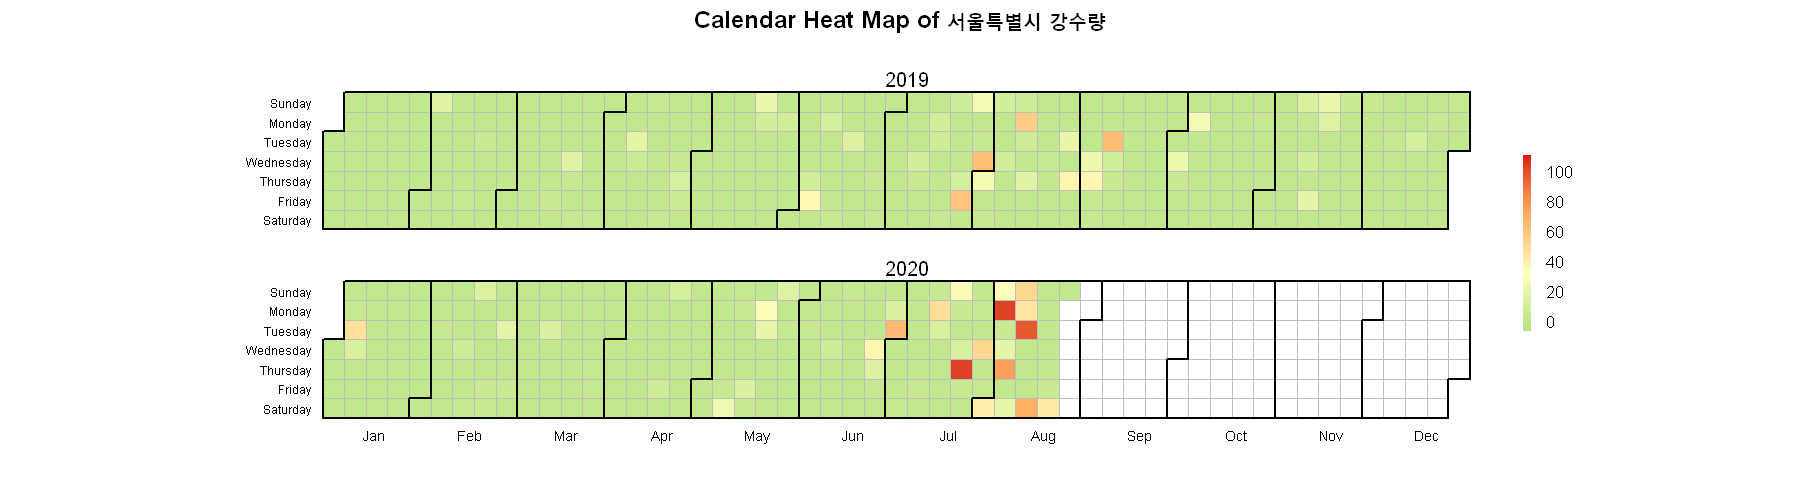

In [42]:
precipitation = fread("C:/Users/USER/dataset/dacon/날씨데이터/강수량.csv")
colnames(precipitation) = c('date', 'loc', 'precipitation')
precipitation$precipitation[is.na(precipitation$precipitation)]=0 # NA to 0
calendarHeat(dates = precipitation$date, values = precipitation$precipitation, color = "g2r", varname = "서울특별시 강수량", )

강수량 역시 3월 기준으로 전년도와 크게 다르지 않았습니다. 조금 더 명확하게 구분하기 위하여 비가 오지 않은(강수량이 0인) 날짜만 시각화 해봤습니다.

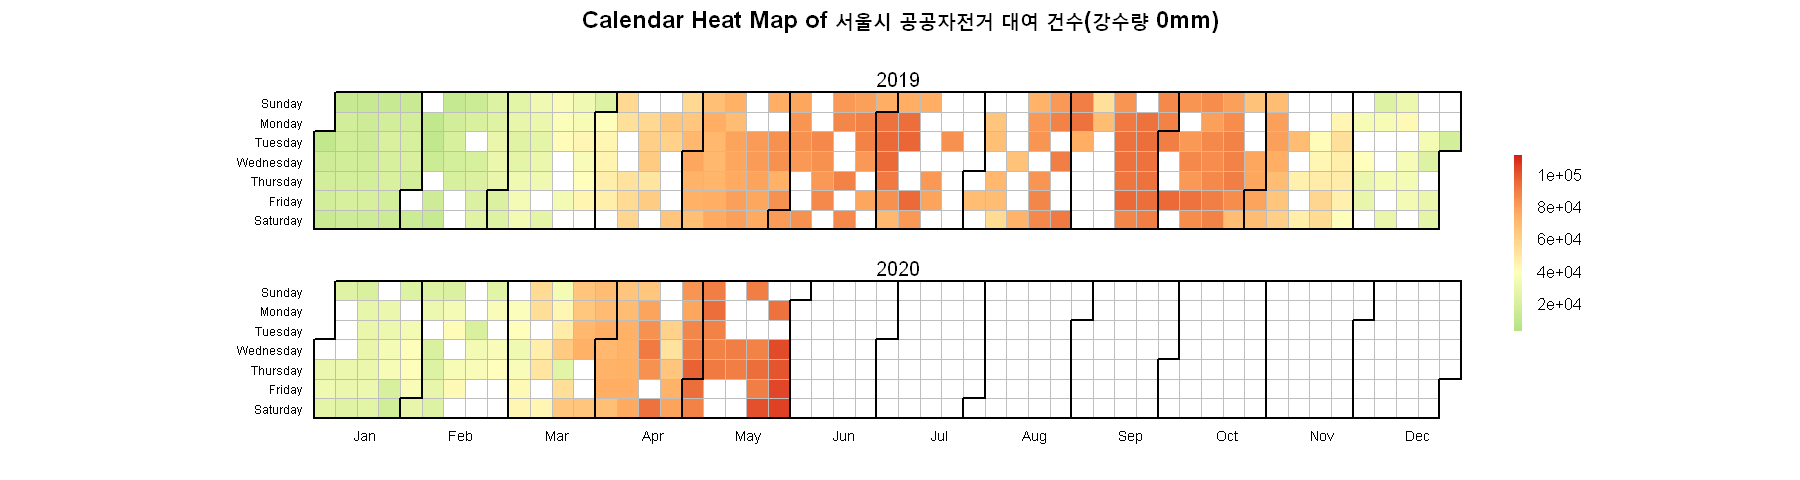

In [44]:
seoul_bike$date = as.character(seoul_bike$date)
precipitation$date = as.character(precipitation$date)
merge_ps = merge(precipitation, seoul_bike)
merge_ps2 = merge_ps
merge_ps2[merge_ps2$precipitation!=0]$count = NA
calendarHeat(dates = merge_ps2$date, values = merge_ps2$count, color = "g2r", varname = "서울시 공공자전거 대여 건수(강수량 0mm)", )

이를 통해 **코로나 확진자가 급증한 이후**로 상대적으로 안전한 이동수단인 **공공 자전거의 수요가 증가**한 것을 확인할 수 있습니다.

## 결론

코로나 확진자의 증가가 국민들의 이동 패턴에 어떠한 변화를 일으켰는지 자가용 차, 대중교통, 유동인구, 공공자전거 및 날씨 데이터를 통해 살펴보았습니다. 거리두기가 중요한 만큼 사람들이 많이 이용하는 대중교통 이용 감소는 자가용 차의 증가로 이어집니다. 도로의 용량은 한정되어 있기 때문에 이러한 **자가용 차의 증가**는 **교통 혼잡**을 불러 일으킬 수 있고, **교통 혼잡 비용은 날이 갈수록 증가**하고 있습니다.

<img src="https://drive.google.com/uc?export=download&id=1HMA4ssKVCZ0D4nhFpi6Mmx5sTcy8CTec" style="width:60%">

이러한 문제를 해결하기 위해 대중교통과 자동차를 대신할 수 있는 **안전하고 편리한 개인 이동 수단**이 필요합니다. 대표적인 예로 자전거가 있으며 서울시 공공 자전거 대여 건수와 신규 가입자 수 분석을 통해 실제로 많은 사람들이 대체 이동 수단으로 자전거를 선택한 것을 확인할 수 있었습니다.

## 대안책 - 자전거를 편리하고 안전한 이동 수단으로!

자전거를 편리하고 안전한 이동 수단으로 이용하기 위해서는 몇 가지 이슈가 있습니다.  

**첫 번째로**, **자전거 도로가 많이 부족**한 상황입니다([강북 따릉이가 더 위험한 이유…](http://newslabit.hankyung.com/article/201803086185G)). 그렇다고 **무작정 자전거 도로를 늘리는 것**은 **기존의 인도나 차도의 폭을 줄어들게 하여 오히려 불편함을 유발**할 수도 있습니다. 공유 자전거의 **O-D 패턴 및 수요 등을 분석**하여 **꼭 필요한 경로에 자전거 도로를 확충**하는 것이 중요한 과제가 될 것입니다.  

**두 번째는**, 스마트폰으로 공공 자전거를 이용하기 때문에 **스마트폰이 익숙하지 않은 어르신들은 이용하기 어렵습니다**. 버스나 지하철을 이용하듯이 **공공자전거 대여소에 교통카드를 태그하는 방식으로 변화**한다면 누구나 쉽게 이용 가능해질 것입니다.  

**세 번째로**, **출퇴근 길에 오르막이 많은 경우** 이용하기 꺼려진다는 점입니다. 운동이라고 생각하고 탄다면 문제가 되지 않지만, 날이 더운 경우 땀을 뻘뻘 흘리며 출근하게 되는 불상사가 생깁니다. 이를 해결하기 위한 방법은 **전기 자전거**가 있습니다. 이미 카카오에서 카카오 T 바이크 라는 것을 도입하여 전기 자전거 대여 서비스를 제공하고 있습니다([인천 연수구 '공유 전기자전거' 1천대 도입…자전거 활성화 추진](https://www.mk.co.kr/news/society/view/2019/02/104256/)). 각 **지자체에서도 공용 전기자전거 충전소 및 대여소를 설치**하고, **기존의 공공자전거와 다른 가격 정책**을 사용하여 서비스한다면 더욱 많은 사람이 자전거를 이용할 것으로 전망됩니다.

(8/28 추가)  
**마지막으로**, 여러 사람이 사용하다보니 **손잡이를 통한 감염 위험**이 있습니다. [서울 관악구, 1천700여명 투입해 10일까지 코로나19 집중방역](https://m.yna.co.kr/view/AKR20200702047500004) 해당 기사의 이미지를 보면 공공 자전거의 손잡이를 사람이 직접 닦고 있습니다. 모든 공공 자전거를 사람이 직접 소독하는 것은 많은 인력과 시간이 소모됩니다.  
이를 해결할 수 있는 방법에는 **두 가지**가 있습니다.  
+ 이번에 [LG 이노텍에서 개발한 에스컬레이터 살균기](http://www.epnc.co.kr/news/articleView.html?idxno=76031)와 마찬가지로 기계가 대신할 수 있다고 생각합니다. 현재 자전거 거치대에는 자전거의 앞 바퀴만 끼우고 연결 고리를 거는 것으로 되어 있습니다. 여기에 **손잡이를 끼우는 부분을 추가하고 자외선 살균 기능**을 넣는다면 사람들이 더욱 안심하고 이용할 것입니다.  
+ 다른 하나는 [NanoSeptic](https://www.autoevolution.com/news/wheels-launches-self-cleaning-e-bikes-to-prevent-covid-19-infection-142362.html)과 같은 기술을 적용하는 것입니다. NanoSeptic은 **빛으로 자체 소독**하는 특징을 가지고 있습니다. 미네랄 나노 결정을 사용하여 빛이 결정에 부딪히면 위험한 화학 물질을 사용하지 않고 표백제보다 강한 산화 반응으로 소독되는 방식입니다. **스킨과 같은 형태**라 **유지 보수를 하기엔 자외선 살균기보다 용이**하지만, 직접적으로 소독되고 있다는 느낌은 받지 못 하여 되려 찜찜한 느낌이 들 수는 있을 것 같습니다.

### 긴 글 읽어주셔서 감사합니다. 아직 부족한 내용이 많습니다. 
### 대회가 끝나는 날까지 계속해서 보완하도록 하겠습니다.
### 피드백은 언제나 환영입니다. 
## 감사합니다!

---

본 저작물의 저작권은 Apache License v2.0을 따릅니다